<a href="https://colab.research.google.com/github/stiflerGit/CAD-Mammography/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

work_dir = "./drive/My Drive/CNN/"
if not os.path.exists(work_dir):
  os.makedirs(work_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

train_gray_imgs = np.load("/content/drive/My Drive/CI_FinalProject/Copia di train_img_224.npy")
train_lbls = np.load("drive/My Drive/CI_FinalProject/Copia di train_lab.npy")

print(train_lbls.shape) # 2864 images (it is a quite small dataset)
print(np.count_nonzero(train_lbls)) # 1546 
# 1546 images belong to class 1, this means 1318 images belong to class 0
# so our class distribution is good

# we have to equally distribute otherwise the error:
### Training and validation subsets have different number of classes after the 
### split. If your numpy arrays are sorted by the label, you might want to shuffle them.
# could be raised. This is due to the distribution of classes of the labels.
# for example after the split, the training labels set contains both class 1 and 2,
# and on the other hand validation labels set contains either class 1 or class 2.
# Even if the train data would cointain both the classes it's better to equally 
# distribute the two classes over the sets.
val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_gray_imgs, train_lbls,
                                                  test_size=val_split, 
                                                  stratify=train_lbls)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))
del(X_train, X_val)
del(y_train, y_val)

# this is done to transform the gray imgs into rgb images
X = np.stack((X,)*3, axis=-1)

del(train_gray_imgs)
del(train_lbls)

test_gray_imgs = np.load("drive/My Drive/CI_FinalProject/Copia di public_test_image_224.npy")
test_rgb_imgs = np.stack((test_gray_imgs,)*3, axis=-1)
test_lbls = np.load("drive/My Drive/CI_FinalProject/Copia di public_test_label.npy")

del(test_gray_imgs)

(2864,)
1546


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=45, 
#                                    zoom_range=[2, 0], 
                                   rescale=1./65536, 
                                   horizontal_flip=True, vertical_flip=True, 
                                   validation_split=val_split)
train_iterator = train_datagen.flow(X, y, batch_size=64, subset='training')

validation_iterator = train_datagen.flow(X, y, batch_size=16, subset='validation')
# validation_iterator = train_datagen.flow(train_rgb_imgs, train_lbls, batch_size=16, subset='validation')

test_datagen = ImageDataGenerator(rescale=1./65536, horizontal_flip=True, vertical_flip=True)

# test_iterator = test_datagen.flow(test_gray_imgs, test_lbls, batch_size=8)
test_iterator = test_datagen.flow(test_rgb_imgs, test_lbls, batch_size=8)

Using TensorFlow backend.


In [4]:
from keras import layers
from keras import models

model = models.Sequential()
# LAYER 1
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 4
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.


In [6]:
from keras import optimizers
from keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# model.fit_generator?
history = model.fit_generator(train_iterator, steps_per_epoch=50, epochs=200,
#                               callbacks=[early_stopping],
                              validation_data=validation_iterator,
                              validation_steps=35)

Epoch 1/200
50/50 [==============================] - 49s 971ms/step - loss: 0.6870 - acc: 0.5704 - val_loss: 0.6820 - val_acc: 0.5216
Epoch 2/200
50/50 [==============================] - 42s 846ms/step - loss: 0.6727 - acc: 0.6007 - val_loss: 0.6600 - val_acc: 0.7122
Epoch 3/200
50/50 [==============================] - 42s 843ms/step - loss: 0.6489 - acc: 0.6512 - val_loss: 0.6360 - val_acc: 0.6547
Epoch 4/200
50/50 [==============================] - 42s 833ms/step - loss: 0.6239 - acc: 0.6682 - val_loss: 0.6422 - val_acc: 0.5180
Epoch 5/200
50/50 [==============================] - 42s 835ms/step - loss: 0.5957 - acc: 0.6949 - val_loss: 0.5717 - val_acc: 0.7626
Epoch 6/200
50/50 [==============================] - 41s 826ms/step - loss: 0.5715 - acc: 0.7255 - val_loss: 0.5457 - val_acc: 0.7698
Epoch 7/200
50/50 [==============================] - 42s 842ms/step - loss: 0.5532 - acc: 0.7270 - val_loss: 0.5331 - val_acc: 0.7824
Epoch 8/200
50/50 [==============================] - 42s 833ms

KeyboardInterrupt: ignored

In [0]:
# from keras.models import Sequential, Model
# from keras import layers

# height = 224
# width = 224

# channels = 3

# num_classes = 2

# model = Sequential()
# model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))
# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.GlobalAveragePooling2D())

# # Dende
# # model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.save_(os.path.join(work_dir, "ScratchCNN03.h5"))

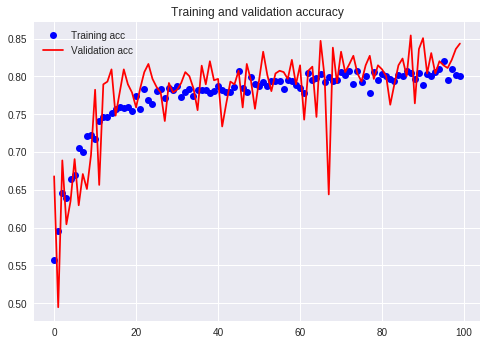

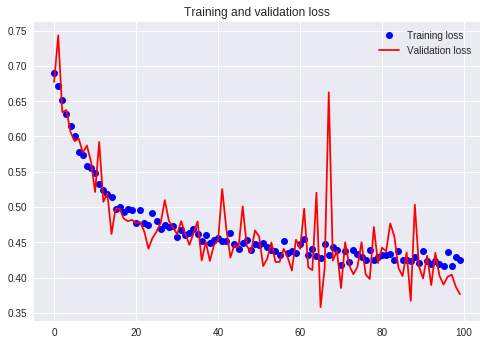

In [0]:
# plot the history
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

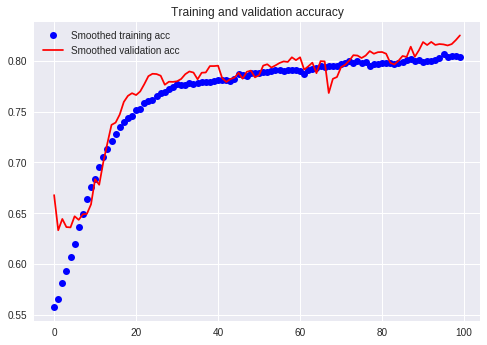

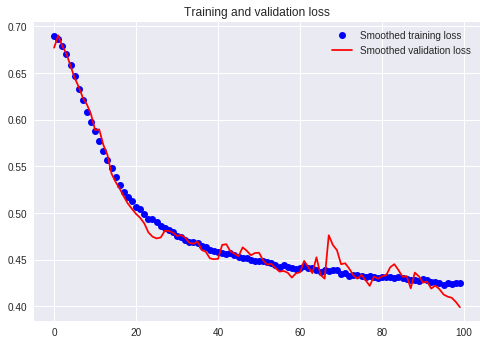

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
results = model.evaluate_generator(test_iterator, steps=22, verbose=1)

print("test_loss: ", results[0], " test_acc: ", results[1])

22/22 [==============================] - 1s 24ms/step
test_loss:  0.36768823252482846  test_acc:  0.8352272727272727


In [0]:
# really slow.... is train set too big?? or steps per epoch too low